# Chandelier layout
The chandelier layout is a layout for hierarchical networks (trees) and DDOT networks. 

Chandelier networks have a circular central hub that is surrounded by a wider circle of subnetworks, each of which has a hierarchical layout. The result is a network that resembles a chandelier viewed from below.

## Requirements
* Open Cytoscape Desktop
* Make sure that Groups are set to show as compound nodes.
   * Go to Edit -> Preferences -> Group Preferences, then make sure that "Visualization for group" is set to "Compound Node".

## Instructions
1. Fill in the user defined constants in cell B.
2. Run cells A to E to split the original graph into subgraphs. Each subgraph will be named the name of the graph, an underscore, and the name of the root node of the subtree contained in the subgraph. Exceptions to this rule are the root subtree (which will have a name ending in '_ROOT'), the subgraph containing unconnected nodes (which will have a name ending in '_UNCONNECTED'), and the 'HUB' graph, which is a metagraph where each node represents a different subgraph (the name of this graph will end in '_HUB').
3. Apply the yFiles radial/circular layout to the subgraph with the title ending in '_ROOT'. (These are the instructions for cell F).
4. Run cell G.
5. Make adjustments to the layouts of any of the subgraphs except for the one with the title ending in '_HUB'. Then run cell H. (If any further adjustments are made to the layouts of these subgraphs, run cell H again.)
6. Apply the yFiles radial/circular layout to the subgraph with the title ending in '_HUB'. Each of the nodes in the HUB graph represents a different subgraph. Changing the layout of the HUB graph will change the final positions of the subgraphs in the original graph. (These are the instructions for cell I).
7. Make adjustments to the HUB graph as you see fit. Then run cell J. (If further adjustments are made to the HUB graph, run cell J again.)

The Chandelier layout should now be applied to the original graph.

A. Imports and constants

In [27]:
import ndex2
import networkx as nx
import networkx.algorithms.dag as dag
from py2cytoscape import cyrest
import json
import requests

#Where to get the network
FILE = 'file' #CX file
UUID = 'uuid' #UUID of NDEx network
CURRENT = 'current' #Current network open in Cytoscape

#API
BASE_URL = 'http://localhost:1234/v1/'
CYNDEX_BASE_URL = 'http://localhost:1234/cyndex2/v1/'

B. User defined constants

In [51]:
#Set this variable to the source of the network (either 'FILE', 'UUID', or 'CURRENT')
USE = CURRENT

#Fill out this information with the network's absolute file path if using FILE
FILE_NAME = '/Users/you/Documents/networks/network.cx'

#Fill out this information if using UUID
NDEX_SERVER = 'ndexbio.org'
NDEX_USERNAME = 'cbass'
NDEX_PASSWORD = 'test12345'
NDEX_NETWORK_UUID = '6192524b-1d11-11ea-bb65-0ac135e8bacf'

#How to determine which branches are called subnetworks ('True' for height, 'False' for number of nodes)
USE_HEIGHT = True
#Fill out this information if using height of tree (not including root node)
HEIGHT = 2
#Fill out this information if not using height
NUMBER_OF_NODES = 5

#Is this a DDOT network?
IS_DDOT_NETWORK = False

#Hierarchical layout constants (positive integers)
HIERARCHICAL_LAYOUT_HORIZONTAL_SPACING = 20
HIERARCHICAL_LAYOUT_VERTICAL_SPACING = 60
#Group padding to be REMOVED from group nodes
GROUP_PADDING = 30

C. Import graph here and in cytoscape

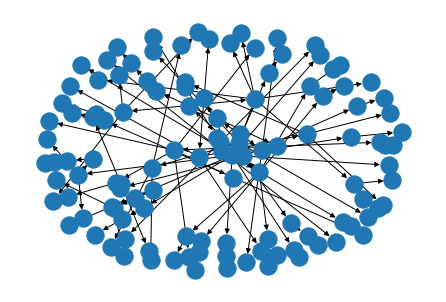

In [52]:
#Import to cytoscape
cy = cyrest.cyclient()
factory = ndex2.nice_cx_network.DefaultNetworkXFactory()

if USE == FILE:
    response = cy.network.load_file(FILE_NAME)
    network_suid = response['networks'][0]
    cx_network = ndex2.create_nice_cx_from_file(FILE_NAME)
elif USE == UUID: 
    url = CYNDEX_BASE_URL + 'networks/'
    body = {
        'serverUrl': NDEX_SERVER,
        'uuid': NDEX_NETWORK_UUID,
        'username': NDEX_USERNAME,
        'password': NDEX_PASSWORD
    }
    headers={'content-type':'application/json', 'Accept':'application/json'}
    response = requests.post(url, json=body, headers=headers)
    network_suid = response.json()['data']['suid']
    cx_network = ndex2.create_nice_cx_from_server(
        NDEX_SERVER,
        username=NDEX_USERNAME,
        password=NDEX_PASSWORD,
        uuid=NDEX_NETWORK_UUID
    )
elif USE == CURRENT:
    url = BASE_URL + 'networks/currentNetwork'
    response = requests.get(url)
    network_suid = response.json()['data']['networkSUID']
    url = BASE_URL + 'networks/views/currentNetworkView'
    response = requests.get(url)
    view_suid = response.json()['data']['networkViewSUID'] 
    response = cy.networks.getNetworkViewAsCx(networkId=network_suid, viewId=view_suid).json()
    cx_network = ndex2.create_nice_cx_from_raw_cx(response)

#Import here as networkx 
network_x = factory.get_graph(cx_network)
nx.draw(network_x)

D. Process networkx network

True


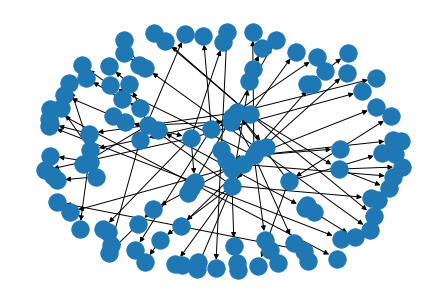

In [53]:
#Process DDOT network
if IS_DDOT_NETWORK:
#Remove non-tree edges
    to_remove = []
    for source, target, attributes in network_x.edges.data():
        if 'Is_Tree_Edge' in attributes:
            if attributes['Is_Tree_Edge'] == 'Not_Tree':
                to_remove.append((source, target))
    for edge in to_remove:
        network_x.remove_edge(edge[0], edge[1])

    # Reverse network
    new_network = network_x.reverse(copy=True)
else:
    new_network = network_x

# Find root node
in_list = [n for n, d in new_network.in_degree() if d == 0]
out_list = [n for n, d in new_network.out_degree() if d != 0]
potential_roots = [n for n in in_list if n in out_list]
if len(potential_roots) == 1:
    root_nxid = potential_roots[0]
else:
    raise SystemExit("More than one potential root node found")

nx.draw(new_network)

#Remove unconnected nodes
connected_nodes = dag.descendants(new_network, root_nxid)
connected_nodes.add(root_nxid)
tree = new_network.subgraph(connected_nodes)

#Find unconnected nodes
unconnected_nodes = list(set(new_network.nodes()) - set(connected_nodes))

#Check for correctness
print(nx.is_arborescence(tree))

#Build maps and get names
#Network name
network_name = cy.network.get_attribute(columnList='name', network='SUID:' + str(network_suid))[0]['name']

#Networkx id to name
nxid_to_name = {}
for nxid, attributes in new_network.nodes.data():
    nxid_to_name[nxid] = attributes['name']

#Name to SUID and SUID to name
name_to_suid = {}
suid_to_name = {}
node_info = cy.node.get_attribute(
    columnList='name,SUID',
    network=network_name
)
for node in node_info:
    name_to_suid[node['name']] = node['SUID']
    suid_to_name[node['SUID']] = node['name']

E. Find and make subgraphs

In [54]:
subgraph_root_name_to_subgraph_node_name_list = {}

root_name = nxid_to_name[root_nxid]
subgraph_root_name_to_subgraph_node_name_list['HUB'] = [root_name]
subgraph_root_name_to_subgraph_node_name_list[root_name] = [root_name]
if len(unconnected_nodes) > 0:
    subgraph_root_name_to_subgraph_node_name_list['UNCONNECTED'] = [nxid_to_name[node] for node in unconnected_nodes]
    subgraph_root_name_to_subgraph_node_name_list['HUB'].append(nxid_to_name[unconnected_nodes[0]])

#Connected nodes
for first_neighbor in tree[root_nxid]:
    #Make subgraph
    descendants = dag.descendants(tree, first_neighbor)
    descendants.add(first_neighbor)
    subgraph = tree.subgraph(descendants)
    
    #Test importance of subgraph
    if USE_HEIGHT:
        if dag.dag_longest_path_length(subgraph, default_weight = 1) > HEIGHT:
            important_subgraph = True
        else:
            important_subgraph = False
    else:
        if len(subgraph) >= NUMBER_OF_NODES:
            important_subgraph = True
        else:
            important_subgraph = False
    
    if important_subgraph:
        #Add to subgraph dictionary
        subgraph_root_name = nxid_to_name[first_neighbor]
        subgraph_node_name_list = [nxid_to_name[nxid] for nxid in descendants]
        subgraph_root_name_to_subgraph_node_name_list[subgraph_root_name] = subgraph_node_name_list

        #Add root to hub
        subgraph_root_name_to_subgraph_node_name_list['HUB'] += [subgraph_root_name]
    else:
        #Add to root subgraph
        subgraph_root_name_to_subgraph_node_name_list[root_name] += [nxid_to_name[nxid] for nxid in descendants]
                
#Make subgraphs in cytoscape
subgraph_name_to_suids = {}
for subgraph_root_name, subgraph_node_name_list in subgraph_root_name_to_subgraph_node_name_list.items():
    if subgraph_root_name == root_name:
        subgraph_name = network_name + '_ROOT'
    else:
        subgraph_name = network_name + '_' + subgraph_root_name
    subgraph_name_to_suids[subgraph_name] = cy.network.create(
        nodeList = ','.join(subgraph_node_name_list),
        networkName = subgraph_name,
        source = network_name
    )
    
#Hide non-tree edges in each subgraph for ddot networks
if IS_DDOT_NETWORK:
    for subgraph_name in subgraph_name_to_suids.keys():
        if subgraph_name == network_name + '_UNCONNECTED':
            continue
        #Find edges to hide
        network_edges = cy.edge.get_attribute(
            network = subgraph_name,
            columnList = 'SUID,Is_Tree_Edge'
        )
        edges_to_hide_list = ['SUID:' + str(edge['SUID']) for edge in network_edges if edge['Is_Tree_Edge'] == 'Not_Tree']
        if len(edges_to_hide_list) > 0:
            edges_to_hide_string = ','.join(map(str, edges_to_hide_list))
        else:
            edges_to_hide_string = 'selected' #Selects no edges

        #Hide edges
        cy.network.hide(
            network = subgraph_name,
            edgeList = edges_to_hide_string,
            nodeList = 'none' #Selects no nodes
        )

**F. Apply the yFiles radial/circular layout to the subgraph with the title ending in '_ROOT'.**

In [ ]:
#Do this by hand for now
raise SystemExit()

G. Apply hierarchical layouts to peripheral subgraphs

In [55]:
for subgraph_name in subgraph_name_to_suids.keys():
    if subgraph_name == network_name + '_ROOT' or subgraph_name == network_name + '_HUB':
        continue
    if subgraph_name == network_name + '_UNCONNECTED':
        cy.layout.grid(
            network = subgraph_name,
            nodeList = ''
        )
        continue
    cy.layout.hierarchical(
        network = subgraph_name,
        nodeHorizontalSpacing = str(HIERARCHICAL_LAYOUT_HORIZONTAL_SPACING),
        nodeVerticalSpacing = str(-int(HIERARCHICAL_LAYOUT_VERTICAL_SPACING)) if IS_DDOT_NETWORK else str(HIERARCHICAL_LAYOUT_VERTICAL_SPACING)
    )
    
#Make each subnetwork a group
for subgraph_root_name, subgraph_node_name_list in subgraph_root_name_to_subgraph_node_name_list.items():
    if subgraph_root_name == 'HUB':
        continue
        
    if subgraph_root_name == root_name:
        subgraph_name = network_name + '_ROOT'
    else:
        subgraph_name = network_name + '_' + subgraph_root_name
        
    body = {
        'name': 'Group ' + subgraph_root_name,
        'nodes': [name_to_suid[name] for name in subgraph_node_name_list]
    }
    headers={'content-type':'application/json', 'Accept':'application/json'}
    url = (BASE_URL 
           +'networks/' 
           + str(subgraph_name_to_suids[subgraph_name]['network']) 
           + '/groups')
    response = requests.post(url, json=body, headers=headers)
    subgraph_name_to_suids[subgraph_name]['group'] = response.json()['groupSUID']

H. Make nodes of those sizes in hub graph (**run this again if you change the layout of any of the subnetworks**)

In [56]:
#Find size and location of each group
subgraph_root_name_to_subgraph_group_dimensions = {}
for subgraph_root_name, subgraph_node_name_list in subgraph_root_name_to_subgraph_node_name_list.items():
    if subgraph_root_name == 'HUB':
        continue
    if subgraph_root_name == root_name:
        subgraph_name = network_name + '_ROOT'
    else:
        subgraph_name = network_name + '_' + subgraph_root_name
    url = (BASE_URL
           + 'networks/'
           + str(subgraph_name_to_suids[subgraph_name]['network'])
           + '/views/'
           + str(subgraph_name_to_suids[subgraph_name]['view'])
           + '/nodes/'
           + str(subgraph_name_to_suids[subgraph_name]['group'])
          )
    response = requests.get(url)
    height = [item['value'] for item in response.json() if item['visualProperty'] == 'NODE_HEIGHT'][0]
    width = [item['value'] for item in response.json() if item['visualProperty'] == 'NODE_WIDTH'][0]
    x_location = [item['value'] for item in response.json() if item['visualProperty'] == 'NODE_X_LOCATION'][0]
    y_location = [item['value'] for item in response.json() if item['visualProperty'] == 'NODE_Y_LOCATION'][0]
    subgraph_root_name_to_subgraph_group_dimensions[subgraph_root_name] = {
        'height': height - GROUP_PADDING if height > GROUP_PADDING else 1,
        'width': width - GROUP_PADDING if width > GROUP_PADDING else 1,
        'x': x_location,
        'y': y_location
    }
    
#Switch to hub graph
cy.view.set_current(network=network_name + '_HUB')

#Update hub graph
height_map = []
width_map = []
shape_map = []
root_name = nxid_to_name[root_nxid]
for hub_node_key in subgraph_root_name_to_subgraph_node_name_list['HUB']:
    if len(unconnected_nodes) > 0 and hub_node_key == nxid_to_name[unconnected_nodes[0]]:
        hub_node_name = 'UNCONNECTED'
    else:
        hub_node_name = hub_node_key
    height_map.append({
        'key': hub_node_key,
        'value': str(subgraph_root_name_to_subgraph_group_dimensions[hub_node_name]['height'])
    })
    width_map.append({
        'key': hub_node_key,
        'value': str(subgraph_root_name_to_subgraph_group_dimensions[hub_node_name]['width'])
    })
    if hub_node_name == root_name:
        shape_map.append({
            'key': hub_node_key,
            'value': 'ELLIPSE'
        })
    else:
        shape_map.append({
            'key': hub_node_key,
            'value': 'ROUND_RECTANGLE'
        })
    
    
style = {
    'title': 'hub_style',
    'defaults': [
        {
            'visualProperty': 'NODE_FILL_COLOR',
            'value': '#89D0F5'
        }
    ],
    'mappings': [
        {
            'mappingType': 'discrete',
            'mappingColumn': 'name',
            'mappingColumnType': 'String',
            'visualProperty': 'NODE_HEIGHT',
            'map': height_map
        },
        {
            'mappingType': 'discrete',
            'mappingColumn': 'name',
            'mappingColumnType': 'String',
            'visualProperty': 'NODE_WIDTH',
            'map': width_map
        },
        {
            'mappingType': 'discrete',
            'mappingColumn': 'name',
            'mappingColumnType': 'String',
            'visualProperty': 'NODE_SHAPE',
            'map': shape_map
        }
    ]
    
}

dependencies = [
    {
        'visualPropertyDependency': 'nodeSizeLocked',
        'enabled': False
    }
]

# Create style
headers={'content-type':'application/json', 'Accept':'application/json'}
response = requests.post(headers=headers, url=BASE_URL + 'styles', json=style)
style_name = response.json()['title']

# Set style dependencies
response = requests.put(headers=headers, url=BASE_URL + 'styles/' + style_name + '/dependencies', json=dependencies)

# Apply style to network
url = BASE_URL + 'apply/styles/' + style_name + '/' + str(subgraph_name_to_suids[network_name + '_HUB']['network'])
response = requests.get(url=url)

**I. Apply the yFiles radial/circular layout to the subgraph with the title ending in '_HUB'.** Each of the nodes in the HUB graph represents a different subgraph. Changing the layout of the HUB graph will change the final positions of the subgraphs in the original graph.

In [ ]:
#Do this manually for now
raise SystemExit("")

J. Calculate new node positions for each node (**run this again if you change the layout of the hub network**)

In [57]:
#Calculate positions of hub nodes
hub_node_name_to_position = {}
x_url = (BASE_URL
       + 'networks/'
       + str(subgraph_name_to_suids[network_name + '_HUB']['network'])
       + '/views/'
       + str(subgraph_name_to_suids[network_name + '_HUB']['view']) 
       + '/nodes?visualProperty=NODE_X_LOCATION'
)
y_url = (BASE_URL
       + 'networks/'
       + str(subgraph_name_to_suids[network_name + '_HUB']['network'])
       + '/views/'
       + str(subgraph_name_to_suids[network_name + '_HUB']['view']) 
       + '/nodes?visualProperty=NODE_Y_LOCATION'
)
x_response_json = requests.get(x_url).json()
y_response_json = requests.get(y_url).json()

for x_item in x_response_json:
    hub_node_name_to_position[suid_to_name[x_item['SUID']]] = {
        'x': x_item['view'][0]['value'],
        'y': [y_item['view'][0]['value'] for y_item in y_response_json if y_item['SUID'] == x_item['SUID']][0]
    }
        
#Calculate other node positions
node_name_to_position = {}
for subgraph_root_name, subgraph_node_name_list in subgraph_root_name_to_subgraph_node_name_list.items():
    if subgraph_root_name == 'HUB':
        continue
        
    if subgraph_root_name == root_name:
        subgraph_name = network_name + '_ROOT'
    else:
        subgraph_name = network_name + '_' + subgraph_root_name
        
    x_url = (BASE_URL
             + 'networks/'
             + str(subgraph_name_to_suids[subgraph_name]['network'])
             + '/views/'
             + str(subgraph_name_to_suids[subgraph_name]['view']) 
             + '/nodes?visualProperty=NODE_X_LOCATION'
    )
    y_url = (BASE_URL
             + 'networks/'
             + str(subgraph_name_to_suids[subgraph_name]['network'])
             + '/views/'
             + str(subgraph_name_to_suids[subgraph_name]['view']) 
             + '/nodes?visualProperty=NODE_Y_LOCATION'
    )
    x_resp = requests.get(x_url).json()
    y_resp = requests.get(y_url).json()

    #Find position of subgraph root
    if subgraph_root_name == 'UNCONNECTED':
        unconnected_root_name = nxid_to_name[unconnected_nodes[0]]
        hub_x = hub_node_name_to_position[unconnected_root_name]['x']
        hub_y = hub_node_name_to_position[unconnected_root_name]['y']
    else:
        hub_x = hub_node_name_to_position[subgraph_root_name]['x']
        hub_y = hub_node_name_to_position[subgraph_root_name]['y']
    group_node_x = subgraph_root_name_to_subgraph_group_dimensions[subgraph_root_name]['x']
    group_node_y = subgraph_root_name_to_subgraph_group_dimensions[subgraph_root_name]['y']
    for x_item in x_resp:
        if x_item['SUID'] not in suid_to_name:
            continue
        node_name = suid_to_name[x_item['SUID']]
        node_name_to_position[node_name] = {
            'x': x_item['view'][0]['value'] - group_node_x + hub_x,
            'y': ([y_item['view'][0]['value'] 
                     for y_item in y_resp 
                     if y_item['SUID'] == x_item['SUID']][0]
                  - group_node_y
                  + hub_y
                 )
        }

#Move nodes to new positions
cy.view.set_current(network=network_name)
for node_name, position in node_name_to_position.items():
    cy.node.set_properties(
        network = network_name,
        nodeList = node_name,
        propertyList = 'X Location, Y Location',
        valueList = str(position['x']) + ',' + str(position['y'])
    )